In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/affinemnist/test.mat
/kaggle/input/affinemnist/validation.mat
/kaggle/input/affinemnist/training_batches/training_batches/31.mat
/kaggle/input/affinemnist/training_batches/training_batches/21.mat
/kaggle/input/affinemnist/training_batches/training_batches/16.mat
/kaggle/input/affinemnist/training_batches/training_batches/28.mat
/kaggle/input/affinemnist/training_batches/training_batches/7.mat
/kaggle/input/affinemnist/training_batches/training_batches/26.mat
/kaggle/input/affinemnist/training_batches/training_batches/27.mat
/kaggle/input/affinemnist/training_batches/training_batches/3.mat
/kaggle/input/affinemnist/training_batches/training_batches/24.mat
/kaggle/input/affinemnist/training_batches/training_batches/6.mat
/kaggle/input/affinemnist/training_batches/training_batches/20.mat
/kaggle/input/affinemnist/training_batches/training_batches/30.mat
/kaggle/input/affinemnist/training_batches/training_batches/14.mat
/kaggle/input/affinemnist/training_batches/training_batc

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch

2025-04-16 18:08:27.749959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744826907.920997      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744826907.972636      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.loc = nn.Sequential(
      nn.BatchNorm2d(1),
      nn.Conv2d(
          in_channels = 1,
          out_channels = 32,
          kernel_size = 5,
          stride = 1
      ),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(
          kernel_size = 2,
          stride = 2
      ),
      nn.Conv2d(
          in_channels = 32,
          out_channels = 64,
          kernel_size = 5,
          stride = 1
      ),
      nn.BatchNorm2d(64),
      nn.ReLU()
      )
    self.locfc = nn.Sequential(
            nn.Linear(64*14*14, 20),
            nn.ReLU(),
            nn.Linear(20, 6)
        )
    self.locfc[2].weight.data.zero_()
    self.locfc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    self.cov = nn.Sequential(
        nn.Conv2d(
            in_channels = 1,
            out_channels = 32,
            kernel_size = 9,
            stride = 1
        ),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        ),
        nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = 7,
            stride = 1
        ),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    )

    self.cnnout = nn.Sequential(
      nn.Linear(64*5*5,20),
      nn.ReLU(),
      nn.Linear(20,10)
    )
    self.log_softmax = F.log_softmax
  def forward(self,x):
    b,c,h,w = x.shape
    theta = self.loc(x)
    theta = theta.view(-1,64*14*14)
    theta = self.locfc(theta)
    theta = theta.view(-1,2,3)
    grid = F.affine_grid(theta,torch.Size((b,c,h,w)),align_corners=True)
    x = F.grid_sample(x,grid,align_corners=True)
    x = self.cov(x)
    x = x.view(-1,64*5*5)
    x = self.cnnout(x)
    return F.log_softmax(x, dim=1)

In [5]:
cnn = CNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn.to(device)

CNN(
  (loc): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (locfc): Sequential(
    (0): Linear(in_features=12544, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=6, bias=True)
  )
  (cov): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(7

In [6]:
import kagglehub
from scipy.io.matlab import loadmat

In [6]:
# Download latest version
path = kagglehub.dataset_download("kmader/affinemnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/affinemnist


In [7]:
# !pwd
# !mv /root/.cache/kagglehub/datasets/kmader/affinemnist/versions/1 /content

In [7]:
image_path = '/kaggle/input/affinemnist/validation.mat'
temp = loadmat(image_path)
sz = temp['affNISTdata']['image'][0][0].shape[-1]
x_val = temp['affNISTdata']['image'][0][0].reshape(40, 40, sz)
x_val = np.moveaxis(x_val, -1, 0)
x_val = np.expand_dims(x_val, axis=-1)
x_val = x_val/255.0

y_val = temp['affNISTdata']['label_int'][0][0]
y_val = np.moveaxis(y_val, -1, 0)
y_val = y_val.astype(np.int32)

In [8]:
image_path = '/kaggle/input/affinemnist/test.mat'
temp = loadmat(image_path)
sz = temp['affNISTdata']['image'][0][0].shape[-1]
x_test = temp['affNISTdata']['image'][0][0].reshape(40, 40, sz)
x_test = np.moveaxis(x_test, -1, 0)
x_test = np.expand_dims(x_test, axis=-1)
x_test = x_test/255.0

y_test = temp['affNISTdata']['label_int'][0][0]
y_test = np.moveaxis(y_test, -1, 0)
y_test = y_test.astype(np.int32)

In [9]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

val_losses = []
val_accuracies = []
train_losses_files = []
for i in range(32):
    path = f"/kaggle/input/affinemnist/training_batches/training_batches/{i+1}.mat"
    temp = loadmat(path)
    sz = temp['affNISTdata']['image'][0][0].shape[-1]
    x = temp['affNISTdata']['image'][0][0].reshape(40, 40, sz)
    x = np.moveaxis(x, -1, 0)
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    y = temp['affNISTdata']['label_int'][0][0]
    y = np.moveaxis(y, -1, 0)
    y = y.astype(np.int32)
    
    train_data = TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    
    val_data = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
    
    train_losses = []
    
    for epoch in range(10):
        epoch_loss = 0
        correct = 0
        total = 0
        with tqdm(train_loader, desc=f"File {i+1} - Epoch {epoch + 1}", leave=False) as pbar:
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(device), target.to(device)
                data = data.view(-1, 1, 40, 40)
                target = target.view(-1)

                pred = cnn(data)
                l = loss(pred, target)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()

                epoch_loss += l.item()
                avg_loss = epoch_loss / (batch_idx + 1)
                pbar.set_postfix({'Loss': f'{avg_loss:.4f}'})

        train_losses.append(epoch_loss / len(train_loader))

    train_losses_files.append(train_losses[-1])

    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 1, 40, 40)
            target = target.view(-1)

            pred = cnn(data)
            _, predicted = torch.max(pred.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            val_loss += loss(pred, target).item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    print(f"Validation Accuracy: {val_accuracies[-1]:.2f}%")

Validation Accuracy: 97.42%


Validation Accuracy: 97.10%


Validation Accuracy: 98.32%


Validation Accuracy: 97.93%


Validation Accuracy: 98.66%


Validation Accuracy: 98.50%


Validation Accuracy: 98.79%


Validation Accuracy: 98.85%


Validation Accuracy: 98.37%


Validation Accuracy: 98.56%


Validation Accuracy: 98.77%


Validation Accuracy: 98.83%


Validation Accuracy: 98.92%


Validation Accuracy: 98.78%


Validation Accuracy: 98.81%


Validation Accuracy: 98.94%


Validation Accuracy: 99.02%


Validation Accuracy: 99.06%


Validation Accuracy: 99.11%


Validation Accuracy: 98.81%


Validation Accuracy: 99.22%


Validation Accuracy: 99.09%


Validation Accuracy: 92.78%


Validation Accuracy: 99.22%


Validation Accuracy: 99.14%


Validation Accuracy: 99.18%


Validation Accuracy: 99.14%


Validation Accuracy: 99.19%


Validation Accuracy: 99.14%


Validation Accuracy: 99.18%


Validation Accuracy: 98.85%


Validation Accuracy: 99.15%


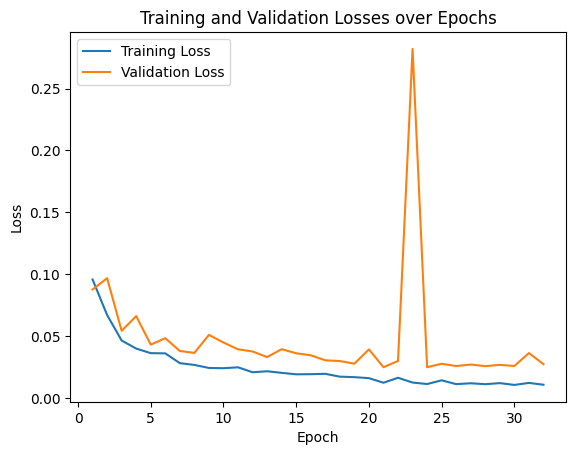

In [12]:
plt.plot(range(1, len(train_losses_files) + 1), train_losses_files, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.show()

In [13]:
test_data = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 1, 40, 40)
        target = target.view(-1)

        pred = cnn(data)
        _, predicted = torch.max(pred.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_accuracy = 100 * correct / total
print(f"STN-CNN Test Accuracy: {test_accuracy:.2f}%")

STN-CNN Test Accuracy: 99.23%


In [14]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=9,
                stride=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=7,
                stride=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 5 * 5, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

In [19]:
baseline_cnn = BaselineCNN()
baseline_cnn.to(device)
optimizer = torch.optim.SGD(baseline_cnn.parameters(), lr=0.01)

In [20]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

baseline_val_losses = []
baseline_val_accuracies = []
baseline_train_losses_files = []
for i in range(32):
    path = f"/kaggle/input/affinemnist/training_batches/training_batches/{i+1}.mat"
    temp = loadmat(path)
    sz = temp['affNISTdata']['image'][0][0].shape[-1]
    x = temp['affNISTdata']['image'][0][0].reshape(40, 40, sz)
    x = np.moveaxis(x, -1, 0)
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    y = temp['affNISTdata']['label_int'][0][0]
    y = np.moveaxis(y, -1, 0)
    y = y.astype(np.int32)
    
    train_data = TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    
    val_data = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
    
    train_losses = []
    
    for epoch in range(10):
        epoch_loss = 0
        with tqdm(train_loader, desc=f"File {i+1} - Epoch {epoch + 1}", leave=False) as pbar:
            for batch_idx, (data, target) in enumerate(pbar):
                data, target = data.to(device), target.to(device)
                data = data.view(-1, 1, 40, 40)
                target = target.view(-1)

                pred = baseline_cnn(data)
                l = loss(pred, target)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()

                epoch_loss += l.item()
                avg_loss = epoch_loss / (batch_idx + 1)
                pbar.set_postfix({'Loss': f'{avg_loss:.4f}'})

        train_losses.append(epoch_loss / len(train_loader))

    baseline_train_losses_files.append(train_losses[-1])

    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 1, 40, 40)
            target = target.view(-1)

            pred = baseline_cnn(data)
            _, predicted = torch.max(pred.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            val_loss += loss(pred, target).item()

    baseline_val_losses.append(val_loss / len(val_loader))
    baseline_val_accuracies.append(100 * correct / total)
    print(f"Validation Accuracy: {baseline_val_accuracies[-1]:.2f}%")

Validation Accuracy: 90.36%


Validation Accuracy: 87.80%


Validation Accuracy: 93.98%


Validation Accuracy: 96.18%


Validation Accuracy: 96.71%


Validation Accuracy: 96.51%


Validation Accuracy: 96.86%


Validation Accuracy: 96.71%


Validation Accuracy: 97.43%


Validation Accuracy: 97.33%


Validation Accuracy: 97.44%


Validation Accuracy: 97.79%


Validation Accuracy: 97.84%


Validation Accuracy: 97.93%


Validation Accuracy: 97.94%


Validation Accuracy: 98.05%


Validation Accuracy: 97.97%


Validation Accuracy: 98.08%


Validation Accuracy: 98.01%


Validation Accuracy: 97.95%


Validation Accuracy: 98.19%


Validation Accuracy: 98.08%


Validation Accuracy: 98.18%


Validation Accuracy: 98.16%


Validation Accuracy: 98.21%


Validation Accuracy: 98.27%


Validation Accuracy: 98.25%


Validation Accuracy: 98.32%


Validation Accuracy: 98.32%


Validation Accuracy: 98.30%


Validation Accuracy: 98.35%


Validation Accuracy: 98.40%


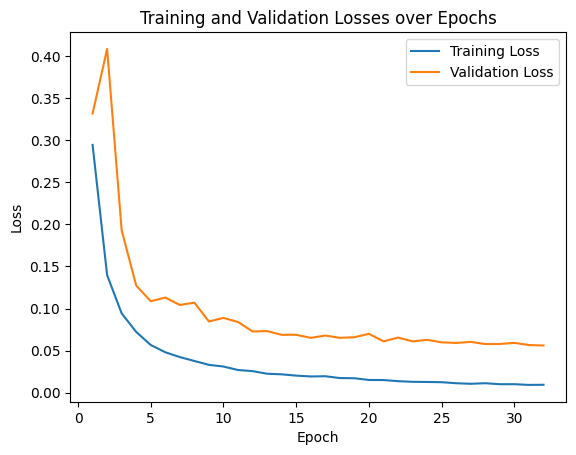

In [21]:
plt.plot(range(1, len(baseline_train_losses_files) + 1), baseline_train_losses_files, label='Training Loss')
plt.plot(range(1, len(baseline_val_losses) + 1), baseline_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.show()

In [33]:
test_data = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 1, 40, 40)
        target = target.view(-1)

        pred = baseline_cnn(data)
        _, predicted = torch.max(pred.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_accuracy = 100 * correct / total
print(f"Baseline CNN Test Accuracy: {test_accuracy:.2f}%")

Baseline CNN Test Accuracy: 98.52%


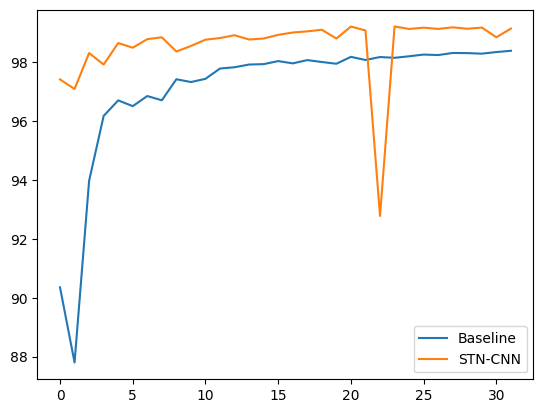

In [29]:
plt.plot(baseline_val_accuracies, label='Baseline')
plt.plot(val_accuracies, label='STN-CNN')
plt.legend()

In [32]:
torch.save(cnn.state_dict(), '/kaggle/working/stn-cnn_weights.pth')
torch.save(baseline_cnn.state_dict(), '/kaggle/working/baseline_cnn_weights.pth')